Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/how-to-use-azureml/training-with-deep-learning/train-hyperparameter-tune-deploy-with-keras/train-hyperparameter-tune-deploy-with-keras.png)

# Deploy with Keras

## Introduction
Stand-alone deploy model based on [train-tune-depploy-with-keras](train-hyperparameter-tune-deploy-with-keras.ipynb)

## Initialize workspace
Initialize a [Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace) object from the existing workspace you created in the Prerequisites step. `Workspace.from_config()` creates a workspace object from the details stored in `config.json`.

In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
import azureml
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.60


In [3]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: dl01
Azure region: uksouth
Subscription id: 51799227-bd67-4e34-96c2-fa93ef5da18d
Resource group: tom


## Show some sample images
Let's load the downloaded compressed file into numpy arrays using some utility functions included in the `utils.py` library file from the current folder. Then we use `matplotlib` to plot 30 random images from the dataset along with their labels.

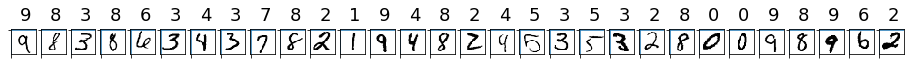

In [4]:
from utils import load_data, one_hot_encode

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster.
X_train = load_data('./data/mnist/train-images.gz', False) / 255.0
y_train = load_data('./data/mnist/train-labels.gz', True).reshape(-1)

X_test = load_data('./data/mnist/test-images.gz', False) / 255.0
y_test = load_data('./data/mnist/test-labels.gz', True).reshape(-1)

count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 10, y = -10, s = y_train[i], fontsize = 18)
    plt.imshow(X_train[i].reshape(28, 28), cmap = plt.cm.Greys)
plt.show()

## Find the registered model
Find the model you want to use

In [6]:
from azureml.core.model import Model 
model = Model(ws, name='keras-mlp-mnist')
print(model)

Model(workspace=Workspace.create(name='dl01', subscription_id='51799227-bd67-4e34-96c2-fa93ef5da18d', resource_group='tom'), name=keras-mlp-mnist, id=keras-mlp-mnist:2, version=2, tags={}, properties={})


## Deploy the model in ACI
Now we are ready to deploy the model as a web service running in Azure Container Instance [ACI](https://azure.microsoft.com/en-us/services/container-instances/). Azure Machine Learning accomplishes this by constructing a Docker image with the scoring logic and model baked in.
### Create score.py
First, we will create a scoring script that will be invoked by the web service call. 

* Note that the scoring script must have two required functions, `init()` and `run(input_data)`. 
  * In `init()` function, you typically load the model into a global object. This function is executed only once when the Docker container is started. 
  * In `run(input_data)` function, the model is used to predict a value based on the input data. The input and output to `run` typically use JSON as serialization and de-serialization format but you are not limited to that.

In [7]:
%%writefile score.py
import json
import numpy as np
import os
from keras.models import model_from_json

from azureml.core.model import Model

def init():
    global model
    
    model_root = Model.get_model_path('keras-mlp-mnist')
    # load json and create model
    json_file = open(os.path.join(model_root, 'model.json'), 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    # load weights into new model
    model.load_weights(os.path.join(model_root, "model.h5"))   
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = np.argmax(model.predict(data), axis=1)
    return y_hat.tolist()

Overwriting score.py


### Create myenv.yml
We also need to create an environment file so that Azure Machine Learning can install the necessary packages in the Docker image which are required by your scoring script. In this case, we need to specify conda packages `tensorflow` and `keras`.

In [8]:
from azureml.core.runconfig import CondaDependencies

cd = CondaDependencies.create()
cd.add_conda_package('tensorflow')
cd.add_conda_package('keras')
cd.save_to_file(base_directory='./', conda_file_path='myenv.yml')

print(cd.serialize_to_string())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-defaults==1.0.60.*
- tensorflow
- keras
channels:
- conda-forge



### Deploy to ACI
We are almost ready to deploy. Create a deployment configuration and specify the number of CPUs and gigbyte of RAM needed for your ACI container. 

In [9]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               auth_enabled=True, # this flag generates API keys to secure access
                                               memory_gb=1, 
                                               tags={'name':'mnist', 'framework': 'Keras'},
                                               description='Keras MLP on MNIST')

#### Deployment Process
Now we can deploy. **This cell will run for about 7-8 minutes**. Behind the scene, it will do the following:
1. **Build Docker image**  
Build a Docker image using the scoring file (`score.py`), the environment file (`myenv.yml`), and the `model` object. 
2. **Register image**    
Register that image under the workspace. 
3. **Ship to ACI**    
And finally ship the image to the ACI infrastructure, start up a container in ACI using that image, and expose an HTTP endpoint to accept REST client calls.

In [10]:
from azureml.core.image import ContainerImage

imgconfig = ContainerImage.image_configuration(execution_script="score.py", 
                                               runtime="python", 
                                               conda_file="myenv.yml")

In [11]:
%%time
from azureml.core.webservice import Webservice

service = Webservice.deploy_from_model(workspace=ws,
                                       name='keras-mnist-svc',
                                       deployment_config=aciconfig,
                                       models=[model],
                                       image_config=imgconfig)

service.wait_for_deployment(show_output=True)

Creating image
Running.................................................
Succeeded
Image creation operation finished for image keras-mnist-svc:3, operation "Succeeded"
Running..................
SucceededACI service creation operation finished, operation "Succeeded"
CPU times: user 725 ms, sys: 108 ms, total: 832 ms
Wall time: 5min 48s


**Tip: If something goes wrong with the deployment, the first thing to look at is the logs from the service by running the following command:**

In [12]:
print(service.get_logs())

2019-09-18T09:57:32,048950956+00:00 - rsyslog/run 
2019-09-18T09:57:32,057238900+00:00 - iot-server/run 
2019-09-18T09:57:32,052658376+00:00 - gunicorn/run 
2019-09-18T09:57:32,060537118+00:00 - nginx/run 
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
2019-09-18T09:57:32,398390427+00:00 - iot-server/finish 1 0
2019-09-18T09:57:32,405192263+00:00 - Exit code 1 is normal. Not restarting iot-server.
Starting gunicorn 19.9.0
Listening at: http://127.0.0.1:31311 (10)
Using worker: sync
worker timeout is set to 300
Booting worker with pid: 47
Initializing logger
Starting up app insights client
Starting up request id generator
Starting up app insight hooks
Invoking user's init function
2019-09-18 09:57:40,163 | azureml.core.run | DEBUG | Could not load run context RunEnvironmentException:
	Message: Could not load a submitted run, if outside of an execution context, use experiment.start_logging to initialize an azureml.core.Run.
	InnerException None
	ErrorResponse 

This is the scoring web service endpoint:

In [13]:
print(service.scoring_uri)

http://2a4657c9-3d47-45a3-a621-7f4bfcdc31ed.uksouth.azurecontainer.io/score


### Test the deployed model
Let's test the deployed model. Pick 30 random samples from the test set, and send it to the web service hosted in ACI. Note here we are using the `run` API in the SDK to invoke the service. You can also make raw HTTP calls using any HTTP tool such as curl.

After the invocation, we print the returned predictions and plot them along with the input images. Use red font color and inversed image (white on black) to highlight the misclassified samples. Note since the model accuracy is pretty high, you might have to run the below cell a few times before you can see a misclassified sample.

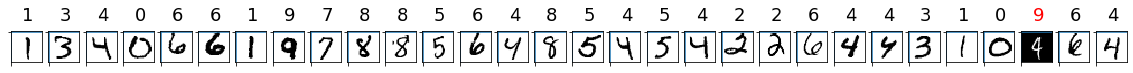

In [18]:
import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')


# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y=-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

We can retreive the API keys used for accessing the HTTP endpoint.

In [19]:
# retreive the API keys. two keys were generated.
key1, Key2 = service.get_keys()
print(key1)

EIxTjTIqhrgiFVdW5pGFmPjqeKFjpfdE


We can now send construct raw HTTP request and send to the service. Don't forget to add key to the HTTP header.

In [20]:
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type':'application/json', 'Authorization': 'Bearer ' + key1}

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)

POST to url http://2a4657c9-3d47-45a3-a621-7f4bfcdc31ed.uksouth.azurecontainer.io/score
label: 3
prediction: [3]


Let's look at the workspace after the web service was deployed. You should see 
* a registered model named 'keras-mlp-mnist' and with the id 'model:1'
* an image called 'keras-mnist-svc' and with a docker image location pointing to your workspace's Azure Container Registry (ACR)  
* a webservice called 'keras-mnist-svc' with some scoring URL

In [21]:
models = ws.models
for name, model in models.items():
    print("Model: {}, ID: {}".format(name, model.id))
    
images = ws.images
for name, image in images.items():
    print("Image: {}, location: {}".format(name, image.image_location))
    
webservices = ws.webservices
for name, webservice in webservices.items():
    print("Webservice: {}, scoring URI: {}".format(name, webservice.scoring_uri))

Model: keras-mlp-mnist, ID: keras-mlp-mnist:2
Image: keras-mnist-svc, location: dl010bb5918d.azurecr.io/keras-mnist-svc:3
Image: myimg01, location: dl010bb5918d.azurecr.io/myimg01:1
Webservice: keras-mnist-svc, scoring URI: http://2a4657c9-3d47-45a3-a621-7f4bfcdc31ed.uksouth.azurecontainer.io/score


## Clean up
You can delete the ACI deployment with a simple delete API call.

In [ ]:
service.delete()